In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import cv2
import IPython.display as ipd
from tqdm import tqdm
import glob
from scipy import signal as sig
import scipy.fft as fft
from numpy.lib.stride_tricks import as_strided

from scipy import ndimage

In [2]:
classDict = {"bed":0,"bird":1,"cat":2,"dog":3,"down":4,"eight":5,"five":6,"four":7,"go":8,"happy":9,"house":10,"left":11,"marvin":12,"nine":13,"no":14,"off":15,"on":16,"one":17,"right":18,"seven":19,"sheila":20,"six":21,"stop":22,"three":23,"tree":24,"two":25,"up":26,"wow":27,"yes":28,"zero":29}

In [3]:
def frames_to_samples(frames, hop_length=512, n_fft=None):

    offset = 0
    if n_fft is not None:
        offset = int(n_fft // 2)

    return (np.asanyarray(frames) * hop_length + offset).astype(int)

In [3]:
def frame(x, frame_length, hop_length, axis=-1):

    if axis == -1 and not x.flags["F_CONTIGUOUS"]:
        x = np.asfortranarray(x)

    elif axis == 0 and not x.flags["C_CONTIGUOUS"]:
        x = np.ascontiguousarray(x)

    n_frames = 1 + (x.shape[axis] - frame_length) // hop_length
    strides = np.asarray(x.strides)

    new_stride = np.prod(strides[strides > 0] // x.itemsize) * x.itemsize

    if axis == -1:
        shape = list(x.shape)[:-1] + [frame_length, n_frames]
        strides = list(strides) + [hop_length * new_stride]

    elif axis == 0:
        shape = [n_frames, frame_length] + list(x.shape)[1:]
        strides = [hop_length * new_stride] + list(strides)

    else:
        print("Frame axis={} must be either 0 or -1".format(axis))

    return as_strided(x, shape=shape, strides=strides)

# Root mean square normalization
def rms(y=None, S=None, frame_length=2048, hop_length=512, center=True, pad_mode="reflect" ):
    
    if y is not None:
        
        if center:
            y = np.pad(y, int(frame_length // 2), mode=pad_mode)

        x = frame(y, frame_length=frame_length, hop_length=hop_length)

        # Calculate power
        power = np.mean(np.abs(x) ** 2, axis=0, keepdims=True)
    elif S is not None:
        # Check the frame length
        if S.shape[0] != frame_length // 2 + 1:
            print(
                "Since S.shape[0] is {}, "
                "frame_length is expected to be {} or {}; "
                "found {}".format(
                    S.shape[0], S.shape[0] * 2 - 2, S.shape[0] * 2 - 1, frame_length
                )
            )

        # power spectrogram
        x = np.abs(S) ** 2

        # Adjust the DC and sr/2 component
        x[0] *= 0.5
        if frame_length % 2 == 0:
            x[-1] *= 0.5

        # Calculate power
        power = 2 * np.sum(x, axis=0, keepdims=True) / frame_length ** 2
    else:
        print("Either `y` or `S` must be input.")

    return np.sqrt(power)

In [4]:
def power_to_db(S, ref=1.0, amin=1e-10, top_db=80.0):
    
    S = np.asarray(S)

    if amin <= 0:
        print("amin must be strictly positive")
        return

    if np.issubdtype(S.dtype, np.complexfloating):
        magnitude = np.abs(S)
    else:
        magnitude = S

    if callable(ref):
        # User supplied a function to calculate reference power
        ref_value = ref(magnitude)
    else:
        ref_value = np.abs(ref)

    log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))
    log_spec -= 10.0 * np.log10(np.maximum(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            print("top_db must be non-negative")
            return
        log_spec = np.maximum(log_spec, log_spec.max() - top_db)

    return log_spec

In [5]:
def amplitude_to_db(S, ref=1.0, amin=1e-5, top_db=80.0):
    
    S = np.asarray(S)

    if np.issubdtype(S.dtype, np.complexfloating):
        print(
            "amplitude_to_db was called on complex input so phase "
            "information will be discarded. To suppress this warning, "
            "call amplitude_to_db(np.abs(S)) instead."
        )

    magnitude = np.abs(S)

    if callable(ref):
        # User supplied a function to calculate reference power
        ref_value = ref(magnitude)
    else:
        ref_value = np.abs(ref)

    power = np.square(magnitude, out=magnitude)

    return power_to_db(power, ref=ref_value ** 2, amin=amin ** 2, top_db=top_db)

In [6]:
def start_end_trim(y, top_db=60, ref=np.max, frame_length=2048, hop_length=512):
    

    mse = rms(y=y, frame_length=frame_length, hop_length=hop_length) ** 2
    non_silent = power_to_db(mse.squeeze(), ref=ref, top_db=None) > -top_db ## Convert power to decibels
     
    nonzero = np.flatnonzero(non_silent)

    if nonzero.size > 0:
        # Compute the start and end positions
        # End position goes one frame past the last non-zero
        start = int(frames_to_samples(nonzero[0], hop_length))
        end = min(y.shape[-1], int(frames_to_samples(nonzero[-1] + 1, hop_length)))
    else:
        # The signal only contains zeros
        start, end = 0, 0


    return start, end

In [7]:
createImages = True
createLabels = True
imageScaler = 1

In [48]:
def bounding_box_creator(signals,classes,hop_length,frame_length,top_db,imagename,labelname,show_image = False):
    
    l = 0
    r = 0 
    t = 0
    b = 0

    partValue = 1.2075

    sr = 22050

    x = 0.416281
    w = 0.830210

    ts = []
    bs = []
    ys = []
    hs = []

    pixel_multiplier_x =  imageScaler/77.5
    pixel_multiplier_y =  1.0265*imageScaler/77.5

    twindow = sig.tukey(frame_length,(2*hop_length)/frame_length)
    
    combined_signal = np.concatenate(signals)

    samples = (combined_signal.shape[0] - (frame_length - hop_length))//hop_length

    a = np.zeros((samples,int(frame_length/2)+1))

    for i in range(samples):
        start = i*hop_length
        end = start + frame_length
#         print('start--, end--',start, end)
        frame = combined_signal[start:end] * twindow
        a[i] = np.fft.rfft(frame)
        
    combined_fft = amplitude_to_db(a, ref=np.max)
    print('combined_fft--',combined_fft.shape[1],combined_fft.shape)
    combined_fft = combined_fft[0:,0:int(frame_length/2)]
    
    print('combined_fft--',combined_fft.shape[1],combined_fft.shape)

    r = int(combined_fft.shape[1]*imageScaler  / partValue)

    for signal in signals:
        start, end = start_end_trim(signal, top_db=top_db, frame_length=frame_length, hop_length=hop_length)
        
        print('start, end,len(signal)',start, end,len(signal))

        b = (len(signal) - (frame_length - hop_length))//hop_length

        tnew = int(t + ((b-t)* (len(signal)-end) )/len(signal))
        bnew = int(t + ((b-t)* (len(signal)-start) )/len(signal))
        
        print('b--tnew--bnew--',b,tnew,bnew)

        if tnew - 10 > t:
            tnew = tnew - 10
        if bnew + 10 < b:
            bnew = bnew + 10
        
        ts.append(tnew*imageScaler)
        bs.append(bnew*imageScaler)

    # print (combined_fft.shape)
    # print(samples)

    plt.figure(figsize=(combined_fft.shape[1] * pixel_multiplier_x ,combined_fft.shape[0] * pixel_multiplier_y ),frameon=False)
    
    plt.imshow(combined_fft,cmap='gray',aspect='auto')
    plt.gca().invert_yaxis()
    plt.axis("off")

    plt.savefig( imagename+".jpg", bbox_inches='tight',dpi=100, pad_inches = 0)
    
    if not show_image:
        plt.close()
        plt.clf()
        
    dh = combined_fft.shape[0]*imageScaler

    if show_image :
        img = cv2.imread(imagename+".jpg")
#         print('image--shape',img)
        dh, _, _ = img.shape

    adding_part = 0

    # print(ts,bs,l,r)
    for i in reversed(range(len(signals))):

        if show_image:
            cv2.rectangle(img, (l, ts[i]+adding_part), (r, bs[i]+adding_part), (0, 0, 255), 2)

        ys.append( ( (bs[i]+adding_part)/dh + (ts[i]+adding_part)/dh )/2 )
        hs.append( (bs[i]+adding_part)/dh - (ts[i]+adding_part) /dh )

        adding_part += int(b*signals[i].shape[0]/sr) * imageScaler

    if show_image: 
        plt.imshow(img)

    f = open(labelname+".txt", "w")
    classesR = classes[::-1]
    for i in range(len(signals)):
        
        if ys[i] > 1.0 :
            ys[i] = 0.99
        if hs[i] > 1.0 :
            hs[i] = 0.99
            
        content = str(classesR[i]) + " " + str(x) + " " + str(ys[i])[0:8] + " " + str(w) + " " + str(hs[i])[0:8] + "\n"
        # print(content) 
        f.write(content)
        
    f.close()

    return samples 

combined_fft-- 129 (515, 129)
combined_fft-- 128 (515, 128)
start, end,len(signal) 9600 19200 22050
b--tnew--bnew-- 171 22 96
start, end,len(signal) 4736 21760 22050
b--tnew--bnew-- 171 2 134
start, end,len(signal) 0 14976 22050
b--tnew--bnew-- 171 54 171


C:\Users\Dell\AppData\Local\Temp\ipykernel_20200\529459477.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  a[i] = np.fft.rfft(frame)


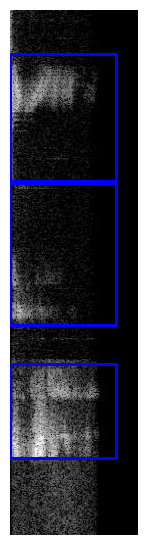

In [51]:

signal1, sampFreq = librosa.load('../../dataset/google_speech_commands_v0/eight/00b01445_nohash_0.wav')
# signal1, sampFreq = librosa.load('sound.wav')

signal2, sampFreq = librosa.load('../../dataset/google_speech_commands_v0/happy/20d3f11f_nohash_0.wav')
signal3, sampFreq = librosa.load('../../dataset/google_speech_commands_v0/right/1f653d27_nohash_0.wav')

# ipd.Audio(data=signal1, rate=sampFreq)

samples_for_image = bounding_box_creator([signal1,signal2,signal3],[1,8,5],128,256,25,"alpha","alpha",True)
# unding_box_creator(signals,classes,hop_length,frame_length,top_db,imagename,labelname,show_image = False):
# samples_for_image = bounding_box_creator([signal1,signal2,signal3],[1,8,5],128,256,25,"alpha","alpha",True)


In [4]:
def start_end_trim_kf(y, top_db=60, ref=np.max, frame_length=2048, hop_length=512):
    
    mse = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)**2 #normalized
    non_silent = librosa.power_to_db(mse.squeeze(), ref=np.max, top_db=None)  > -top_db ## Convert power to decibels
    nonzero = np.flatnonzero(non_silent)

    if nonzero.size > 0:
        # Compute the start and end positions
        # End position goes one frame past the last non-zero
        start = int(frames_to_samples(nonzero[0], hop_length))
        end = min(y.shape[-1], int(frames_to_samples(nonzero[-1] + 1, hop_length)))

    else:
        # The signal only contains zeros
        start, end = 0, 0

    return start, end

In [5]:
def bounding_box_creator_kf(signals,classes,hop_length,frame_length,top_db,imagename,labelname,show_image = False):
    
    t=0   
    # Short-time Fourier Transformation on our audio data
    audio_stft = librosa.core.stft(signals, hop_length=hop_length, n_fft=256)
    # gathering the absolute values for all values in our audio_stft 
    spectrogram = np.abs(audio_stft)
    combined_fft = librosa.amplitude_to_db(spectrogram, ref=np.max) # Converting the amplitude to decibels
    
    fig = plt.figure(figsize=(8,8),frameon=False)
    
    plt.subplot(152)
    rotated_img = ndimage.rotate(combined_fft, 1*90)
#     plt.imshow(rotated_img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.imsave(imagedir+imagename+".jpg",rotated_img)

    start, end = start_end_trim_kf(signals, top_db=top_db, frame_length=frame_length, hop_length=hop_length)
    
    b = (len(signals) - (frame_length - hop_length))//hop_length
    
#     print('len(signals)--end--start-',len(signals),end,start,'-rotated_img',rotated_img.shape)

    tnew = int(t + ((b-t)* (len(signals)-end) )/len(signals))
    bnew = int(t + ((b-t)* (len(signals)-start) )/len(signals))
    
#     cv2.rectangle(rotated_img, (0, tnew), (90, bnew), (0, 0, 255), 2)
#     plt.imshow(rotated_img)
    
    y = (tnew + (bnew - tnew)/2)/rotated_img.shape[0]
    x = (45)/rotated_img.shape[1]
    h = (bnew - tnew)/rotated_img.shape[0]
    w = 90/rotated_img.shape[1]

    f = open(labeldir+labelname+".txt", "w")
    content = str(classes) + " " + str(x) + " " + str(y) + " " + str(w) + " " + str(h) + "\n"
    f.write(content)
    

#     print('b--tnew--bnew--',b,tnew,bnew)

[ 3.6760299e-05  1.1913109e-03  7.8459270e-04 ...  7.0444599e-05
 -1.2223364e-04  4.3568772e-04]


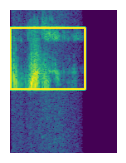

In [125]:
signal1, sampFreq = librosa.load('../../dataset/google_speech_commands_v0/eight/00b01445_nohash_0.wav')
# signal1, sampFreq = librosa.load('../../dataset/google_speech_commands_v0/happy/20d3f11f_nohash_0.wav')

samples_for_image = bounding_box_creator_kf(signal1,[1,8,5],128,256,25,"alphaa","alphaa",True)
# bounding_box_creator_kf(signals,classes,hop_length,frame_length,top_db,imagename,labelname,show_image = False

In [6]:
flist = glob.glob('..\..\dataset\google_speech_commands_v0\*\*')


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x000001AA99AAA480> (for post_execute):



KeyboardInterrupt



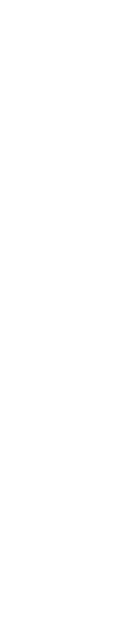

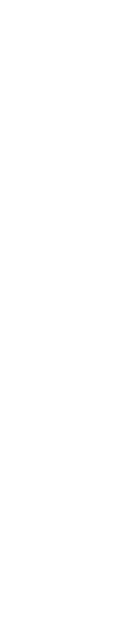

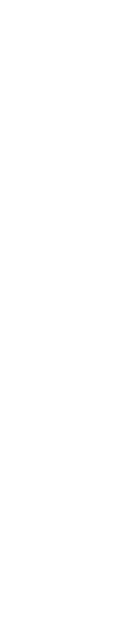

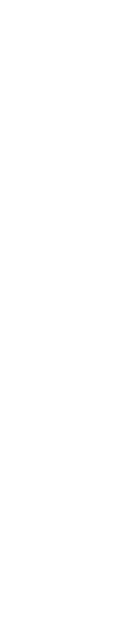

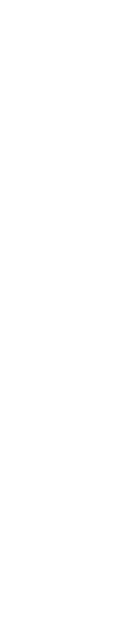

Error in callback <function flush_figures at 0x000001AA99DFBBA0> (for post_execute):



KeyboardInterrupt



In [10]:
for i,wav in enumerate(flist):
    if i < 7000:
        pass
#         imagedir = "..\\..\\dataset\\google_dataset_bw_yolo_new\\images\\train\\"
#         labeldir = "..\\..\\dataset\\google_dataset_bw_yolo_new\\labels\\train\\"
#         classes = wav.split('\\')[-2]
#         img_name = wav.split('\\')[-1]
#         img_name = img_name.split('.')[0]
#         cls_type = classDict.get(classes)
#         signal, sampFreq = librosa.load(wav)
#         samples_for_image = bounding_box_creator_kf(signal,cls_type,128,256,25,img_name,img_name,True)
        
    else:
        imagedir = "..\\..\\dataset\\google_dataset_bw_yolo_new\\images\\val\\"
        labeldir = "..\\..\\dataset\\google_dataset_bw_yolo_new\\labels\\val\\"
        classes = wav.split('\\')[-2]
        img_name = wav.split('\\')[-1]
        img_name = img_name.split('.')[0]
        cls_type = classDict.get(classes)
        signal, sampFreq = librosa.load(wav)
        samples_for_image = bounding_box_creator_kf(signal,cls_type,128,256,25,img_name,img_name,True)
        

#     break

In [13]:
!pip python train.py --data data/sound.yaml --cfg models/yolov5s.yaml --epochs 2 --weights '' --device 0 --name test --batch-size 8 --exist-ok

ERROR: unknown command "python"



Error in callback <function _draw_all_if_interactive at 0x00000145790D62A0> (for post_execute):


KeyboardInterrupt: 

In [41]:
def create_audio_dataset_color_test(dirname,cmap='bwr',nsamples=160,window_size=256,hop_length=128,n_expo=4): # '/mnt/datadrive/datasets/google_speech_commands_dct_v1_kf'
    flist = glob.glob('..\..\dataset\google_speech_commands_v0\*\*')
    filter_func = lambda x: 1 - np.cos(x*np.pi/window_size)**n_expo
    # plt.plot(filter_func(np.arange(window_size)))
    # plt.show()
    # print (len(flist))
    dname = f'{dirname}_{cmap}_h{nsamples}_w{window_size*3//4}'

    
    for index in tqdm(range(0, len(flist)), desc =f"Audio Dataset: {dname}"):    
        fname = flist[index]
        word = fname.split('\\')[-2]
        new_filename = f'{dname}/{word}/{index}.jpg'
        new_dir = f'{dname}/{word}'

        signal, sampFreq = librosa.load(fname)
        plt.figure(figsize=(5, 3))
        librosa.display.waveshow(signal, sr=sampFreq)
        plt.show()

        dct_2d = image_creator_freq_domain(signal, hop_length, window_size,pre_filter=filter_func,nsamples=nsamples)

#         dct_2d = dct_2d[:,:window_size*3//4]
#         print ("image",dct_2d.shape)
#         plt.figure(figsize=(3, 5))
#         plt.imshow(dct_2d,cmap=cmap)
#         plt.title(new_filename)
#         plt.show()
        
        
        start_point = (0, 90)
        end_point = (170, 140)
        thickness = 2
        image1 = cv2.rectangle(dct_2d, start_point, end_point, thickness)
        plt.figure(figsize=(3, 5))
        plt.imshow(image1,cmap=cmap)
        plt.show()
        
        break
       
    return dname

Audio Dataset: ../../dataset/audio_dct_bwr_h160_w192:   0%|                                  | 0/64721 [00:00<?, ?it/s]

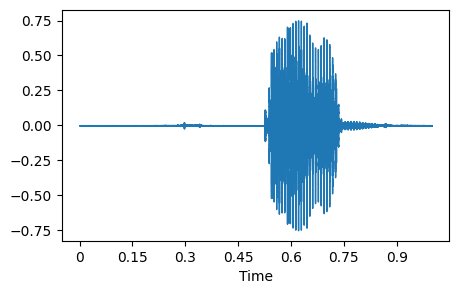

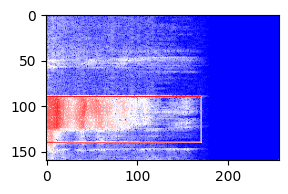

Audio Dataset: ../../dataset/audio_dct_bwr_h160_w192:   0%|                                  | 0/64721 [00:00<?, ?it/s]


'../../dataset/audio_dct_bwr_h160_w192'

In [42]:
create_audio_dataset_color_test('../../dataset/audio_dct',cmap='bwr',n_expo=4)

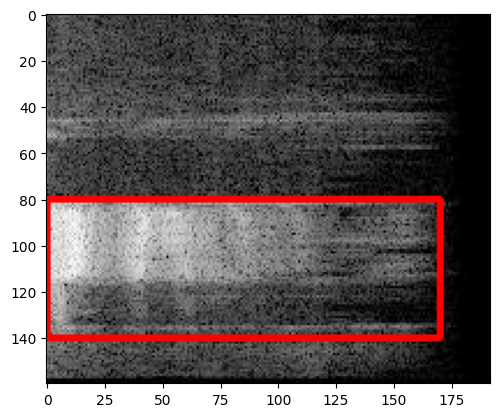

In [30]:
path = r'..\..\dataset\Audio_dct_gray_h160_w192\bed\0.jpg'
   
# Reading an image in default mode
image = cv2.imread(path)
   
# Window name in which image is displayed
window_name = 'Image'
  
# Start coordinate, here (5, 5)
# represents the top left corner of rectangle
start_point = (0, 80)
  
# Ending coordinate, here (220, 220)
# represents the bottom right corner of rectangle
end_point = (170, 140)
  
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2
  
# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
image = cv2.rectangle(image, start_point, end_point, color, thickness)
plt.imshow(image)
plt.show()

In [69]:
import speech_recognition as sr

# Create a recognizer instance
r = sr.Recognizer()

# Open the audio file
with sr.AudioFile('sound.wav') as source:
    audio_data = r.record(source)

# Recognize the speech in the audio
text = r.recognize_google(audio_data)

# Print the recognized text
print(text)

comparative


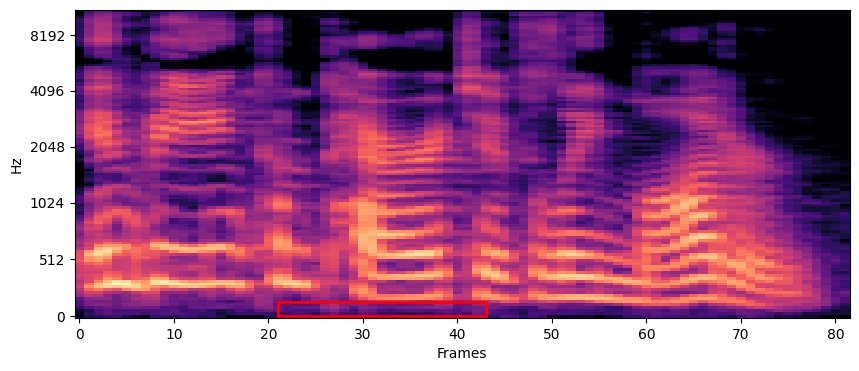

In [108]:
# Load the audio waveform
audio, sr = librosa.load('sound.wav')

# Compute the Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
# mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft)

# Set the time range of the ROI
start_time = 0.5
end_time = 1.0

# Convert the time range to frame indices
start_frame = librosa.time_to_frames(start_time, sr=sr)
end_frame = librosa.time_to_frames(end_time, sr=sr)

# Define the ROI coordinates in Mel spectrogram coordinates
x_min, x_max = start_frame, end_frame
y_min, y_max = 0, mel_spec.shape[0]

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), x_axis='frames', y_axis='mel')

# Add the bounding box to the plot
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

# Show the plot
plt.show()

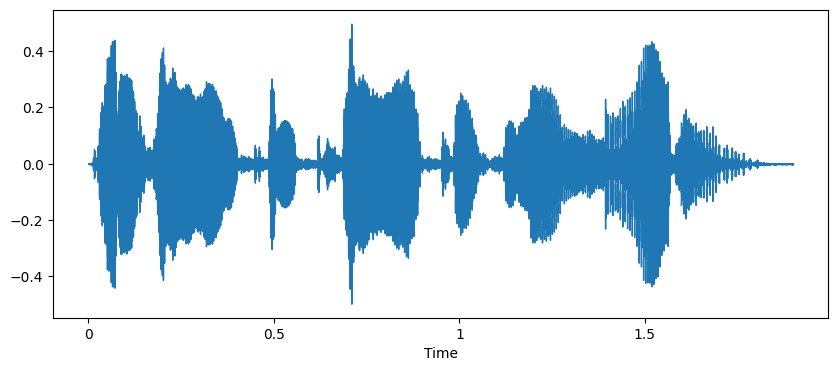

In [113]:
audio, sr = librosa.load('sound.wav')

# Set the time range of the ROI
start_time = 0.5
end_time = 1.0

# Convert the time range to sample indices
start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)

# Add the bounding box to the plot
rect = plt.Rectangle((start_sample, -1), end_sample - start_sample, 2, linewidth=2, edgecolor='r')
plt.gca().add_patch(rect)

# Show the plot
plt.show()